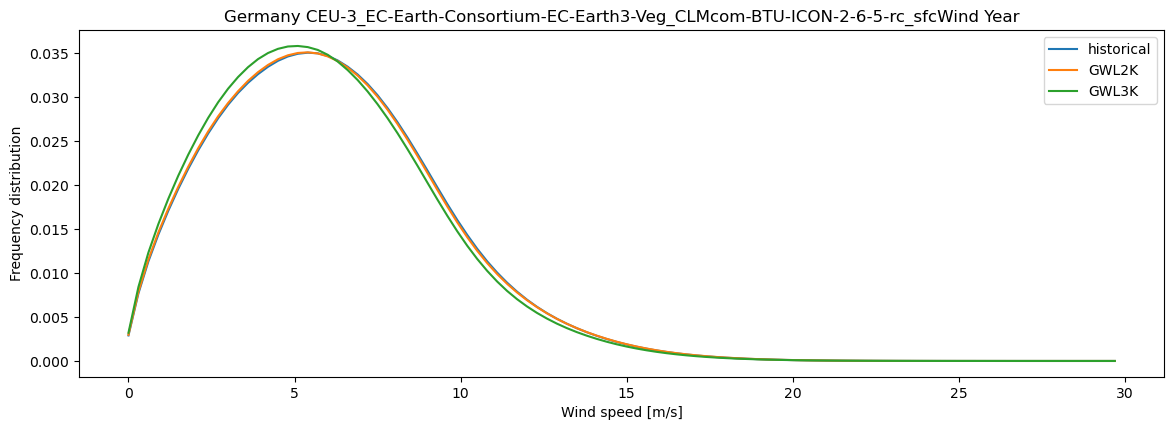

In [1]:
# sfcWind speed histogram
import json

import matplotlib.pyplot as plt
import numpy as np

region = "Germany"
with open(f"sfcWind/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_sfcWind"
    Hereon_data = wind_stats[dataset]
    edges = wind_stats["edges"]
    wind_hist = Hereon_data["historical"]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]

    season = "Year"
    max_count = max(
        wind_hist[season]["counts"]
        + wind_2K[season]["counts"]
        + wind_3K[season]["counts"]
    )
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(
            edges[:-1],
            np.array(data[season]["counts"]) / np.sum(data[season]["counts"]),
            label=labels[index],
        )
        # plt.stairs(data["counts"], edges,label=labels[index])
    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("Frequency distribution")
    plt.xlabel("Wind speed [m/s]")
    plt.legend()
    plt.savefig("Publikation/Figures/Wind_histogram.png", bbox_inches="tight", format="png", dpi=300)
    plt.show()

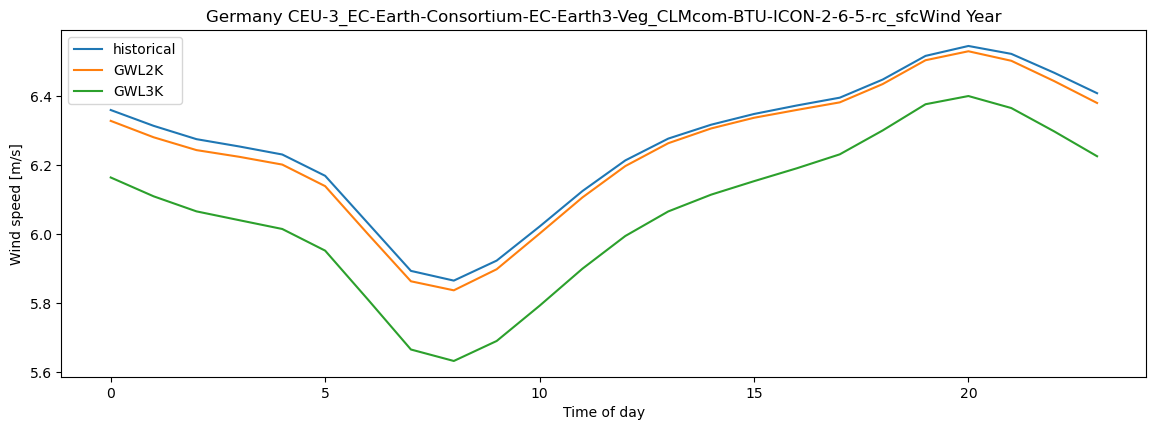

In [2]:
# Wind speed daily cycle
import json
import matplotlib.pyplot as plt

region = "Germany"
with open(f"sfcWind/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_sfcWind"
    Hereon_data = wind_stats[dataset]
    wind_hist = Hereon_data["historical"]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]
    season = "Year"
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(data[season]["diurnal_cycle"], label=labels[index])

    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("Wind speed [m/s]")
    plt.xlabel("Time of day")
    plt.legend()
    plt.savefig("Publikation/Figures/Wind_daily_cycle.png", bbox_inches="tight", format="png", dpi=300)

    plt.show()

In [3]:
# Wind_mean_values
import json
from collections import defaultdict


def latex_escape(s):
    return s.replace("_", "\\_")


# 1) Load data
with open("sfcWind/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

# 2) Flatten out (res, gcm, rcm, scenario, mean) — always use "Year"
season = "Year"
entries = []

for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        # grab mean for Year, skip if missing
        mean_val = stats.get(season, {}).get("mean")
        u_c3M = stats.get(season, {}).get("under_cut_in_3MW")
        u_c5M = stats.get(season, {}).get("under_cut_in_5MW")
        nom3M = stats.get(season, {}).get("nominal_3MW")
        nom5M = stats.get(season, {}).get("nominal_5MW")
        if mean_val is None:
            continue

        entries.append(
            (
                res,
                gcm,
                rcm,
                scen,
                f"{mean_val:.2f}",
                f"{u_c3M:.2f}",
                f"{u_c5M:.2f}",
                f"{nom3M:.2f}",
                f"{nom5M:.2f}",
            )
        )

# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val, u_c3M, u_c5M, nom3M, nom5M in entries:
    grouped[res][gcm][rcm].append((scen, val, u_c3M, u_c5M, nom3M, nom5M))

# 4) Build LaTeX
num_cols = 9  # total columns in the tabular environment

lines = [
    "\\begin{table}[!htbp]",
    "\\centering",
    "\\caption{Mean wind speed grouped by Resolution, GCM, RCM and Scenario}",
    "\\label{Table:Wind_table}",
    "\\resizebox{\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|c|c|c|c|c}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Wind speed & u\\_c3M & u\\_c5M & nom3M & nom5M\\\\",
    "\\midrule",
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(
        len(s_list) for rcm_dict in gcm_blocks.values() for s_list in rcm_dict.values()
    )
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val, u_c3M, u_c5M, nom3M, nom5M in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val, u_c3M, u_c5M, nom3M, nom5M])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\end{table}",
]

replacement_map = {
    "EC-Earth-Consortium-EC-Earth3-Veg": "EC-Earth",
    "MIROC-MIROC6":                 "MIRCO",
    "MPI-M-MPI-ESM1-2-HR":          "MPI-ESM",
    "CLMcom-BTU-ICON-2-6-5-rc":     "BTU-ICON",
    "CLMcom-KIT-CCLM-6-0-clm2":     "KIT-CCLM",
    "CLMcom-Hereon-CCLM-6-0-clm2":  "Hereon-CCLM",
    "CLMcom-Hereon-CCLM-6-0-clm3":  "Hereon-CCLM"
}

with open("Publikation/Tables/Wind_table.tex", "w") as out_file:
    for line in lines:
        for old, new in replacement_map.items():
            line = line.replace(old, new)
        out_file.write(f"{line}\n")


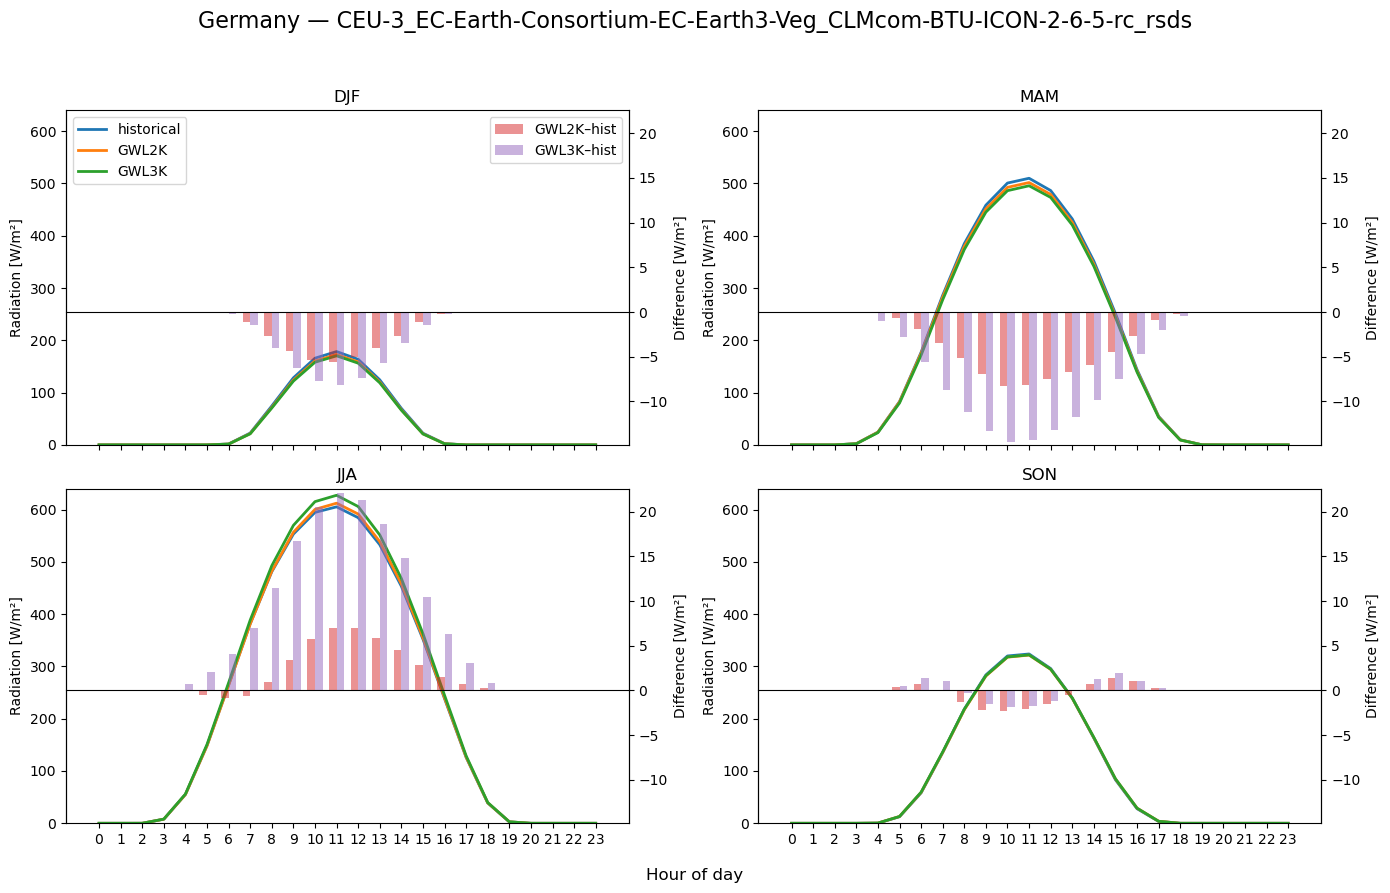

In [4]:
#PV_daily_cycle_all_seasons
import json
import numpy as np
import matplotlib.pyplot as plt

region  = "Germany"
dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_rsds"
seasons = ["DJF", "MAM", "JJA", "SON"]

# Pre-load to compute global limits
all_hist, all_diff2, all_diff3 = [], [], []
for season in seasons:
    with open(f"rsds/{region}.json") as f:
        d    = json.load(f)[dataset]
        hist = np.array(d["historical"][season]["diurnal_cycle"])
        gwl2 = np.array(d["ssp370-GWL2K"][season]["diurnal_cycle"])
        gwl3 = np.array(d["ssp370-GWL3K"][season]["diurnal_cycle"])
    all_hist.append((hist, gwl2, gwl3))
    all_diff2.append(gwl2 - hist)
    all_diff3.append(gwl3 - hist)

# Compute y-limits
hists   = np.concatenate([np.concatenate(x) for x in all_hist])
diffs2  = np.concatenate(all_diff2)
diffs3  = np.concatenate(all_diff3)
rad_min, rad_max   = 0, hists.max() * 1.02
diff_min, diff_max = min(diffs2.min(), diffs3.min()) * 1.02, max(diffs2.max(), diffs3.max()) * 1.02

# Setup 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True)
axes = axes.ravel()
hours = np.arange(len(all_hist[0][0]))

for i, (ax, (hist, gwl2, gwl3), diff2, diff3, season) in enumerate(
        zip(axes, all_hist, all_diff2, all_diff3, seasons)):

    # Plot lines
    ax.plot(hours, hist, color="tab:blue",   lw=2, label="historical")
    ax.plot(hours, gwl2,  color="tab:orange",lw=2, label="GWL2K")
    ax.plot(hours, gwl3,  color="tab:green", lw=2, label="GWL3K")
    ax.set_ylim(rad_min, rad_max)
    ax.set_title(season)
    ax.set_xticks(hours)
    ax.set_ylabel("Radiation [W/m²]")

    # Twin for bars
    ax2 = ax.twinx()
    bw = 0.35
    ax2.bar(hours - bw/2, diff2, width=bw, alpha=0.5, color="tab:red",    label="GWL2K–hist")
    ax2.bar(hours + bw/2, diff3, width=bw, alpha=0.5, color="tab:purple", label="GWL3K–hist")
    ax2.spines["bottom"].set_position(("data", 0))
    ax2.spines["top"].set_visible(False)
    ax2.set_ylim(diff_min, diff_max)
    ax2.set_ylabel("Difference [W/m²]")

    # Only on the first subplot do we add both legends
    if i == 0:
        ax.legend(loc="upper left")
        ax2.legend(loc="upper right")

# Global labels/title
fig.supxlabel("Hour of day")
fig.suptitle(f"{region} — {dataset}", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save & show
fig.savefig("Publikation/Figures/PV_daily_cycle_all_seasons_shared_axes.png", dpi=300)
plt.show()


In [5]:
# PV Table
import json
from collections import defaultdict


def latex_escape(s):
    return s.replace("_", "\\_")


# 1) Load data
with open("rsds/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

# 2) Flatten out (res, gcm, rcm, scenario, mean) — always use "Year"
season = "Year"
entries = []

for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        # grab mean for Year, skip if missing
        mean_val = stats.get(season, {}).get("mean")
        if mean_val is None:
            continue

        entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))


# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5  # total columns in the tabular environment

lines = [
    "\\begin{table}[!htbp]",
    "\\centering",
    "\\caption{Mean rsds grouped by Resolution, GCM, RCM and Scenario}",
    "\\label{Table:rsds_mean_values}",
    "\\resizebox{\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule",
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(
        len(s_list) for rcm_dict in gcm_blocks.values() for s_list in rcm_dict.values()
    )
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\end{table}",
]

replacement_map = {
    "EC-Earth-Consortium-EC-Earth3-Veg": "EC-Earth",
    "MIROC-MIROC6":                 "MIRCO",
    "MPI-M-MPI-ESM1-2-HR":          "MPI-ESM",
    "CLMcom-BTU-ICON-2-6-5-rc":     "BTU-ICON",
    "CLMcom-KIT-CCLM-6-0-clm2":     "KIT-CCLM",
    "CLMcom-Hereon-CCLM-6-0-clm2":  "Hereon-CCLM",
    "CLMcom-Hereon-CCLM-6-0-clm3":  "Hereon-CCLM"
}

with open("Publikation/Tables/PV_table.tex", "w") as out_file:
    for line in lines:
        for old, new in replacement_map.items():
            line = line.replace(old, new)
        out_file.write(f"{line}\n")


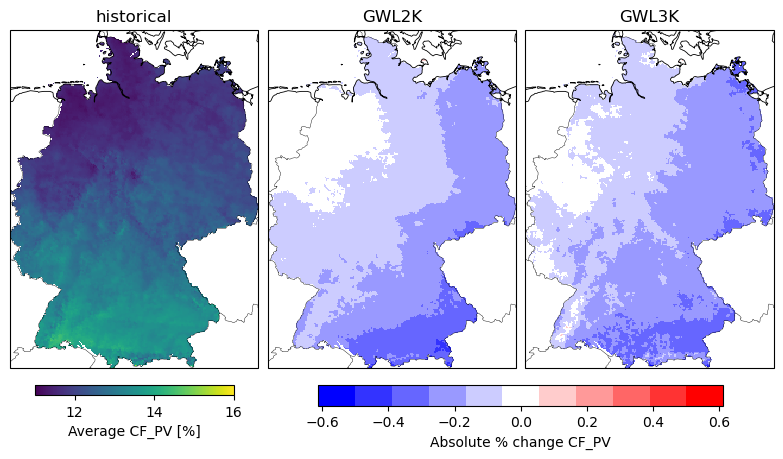

Mean value historical: 12.46%
Mean value GWL2K: 12.31%
Mean value GWL3K: 12.29%
Mean difference GWL2K: -0.15%
Mean difference GWL3K: -0.17%


In [6]:
# Changes to CF_PV
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(
    pole_longitude=198.0, pole_latitude=39.25
)  # Example values

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 4.5),
    subplot_kw=dict(projection=rotated_pole),
    layout="compressed",
)


discrete_cmap = plt.get_cmap("bwr", 11)
discrete_cmap.set_bad(color=(0, 0, 0, 0))

with open("CF_PV/Germany.json", "r", encoding="utf-8") as file:
    file_locations = json.load(file)
    data_location = file_locations[
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_PV"
    ]
    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
    file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

    historical=file_1["CF_PV"].values
    GWL2K = file_2["CF_PV"].values - file_1["CF_PV"].values
    GWL3K = file_3["CF_PV"].values - file_1["CF_PV"].values

    v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
    v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
    if abs(v_min) > abs(v_max):
        v_max = abs(v_min)
    else:
        v_min = -v_max

    files = [GWL2K, GWL3K]
    scenarios = ["GWL2K", "GWL3K"]

    ax=axes[0]
    cf_flaute = historical * 100
    lat = file_1["lat"].values
    lon = file_1["lon"].values

    cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))
    pm1 = ax.pcolormesh(
            lon,
            lat,
            cf_masked,
            cmap="viridis",
            vmin=np.floor(np.nanmin(cf_masked)),
            vmax=np.ceil(np.nanmax(cf_masked)),
            shading="auto",
            transform=ccrs.PlateCarree(),
        )  # Assuming lat/lon are in regular geographic coords

    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_title("historical", fontsize=12)

    for index,(file, scenario) in enumerate(zip(files, scenarios)):
        ax=axes[index+1]
        cf_flaute = file * 100
        lat = file_1["lat"].values
        lon = file_1["lon"].values

        cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))

        pm = ax.pcolormesh(
            lon,
            lat,
            cf_masked,
            cmap=discrete_cmap,
            vmin=v_min,
            vmax=v_max,
            shading="auto",
            transform=ccrs.PlateCarree(),
        )  # Assuming lat/lon are in regular geographic coords

        ax.coastlines(linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.set_title(scenario, fontsize=12)

    cbar = fig.colorbar(
        pm1,
        ax=axes[0],
        orientation="horizontal",
        pad=0.05,
        shrink=0.8,
        label="Average CF_PV [%]",
    )
    cbar = fig.colorbar(
        pm,
        ax=axes[1:3].ravel().tolist(),
        orientation="horizontal",
        pad=0.05,
        shrink=0.8,
        label="Absolute % change CF_PV",
    )
    plt.savefig("Publikation/Figures/CF_PV_change_scenarios.png", bbox_inches="tight", format="png", dpi=300)
    plt.show()

    print(f"Mean value historical: {np.nanmean(file_1['CF_PV'].values)*100:.2f}%")
    print(f"Mean value GWL2K: {file_2['CF_PV'].mean().item()*100:.2f}%")
    print(f"Mean value GWL3K: {file_3['CF_PV'].mean().item()*100:.2f}%")
    print(f"Mean difference GWL2K: {np.nanmean(GWL2K)*100:.2f}%")
    print(f"Mean difference GWL3K: {np.nanmean(GWL3K)*100:.2f}%")

Mean value historical 3_3MW: 42.66%
Mean value GWL2K 3_3MW: 42.37%
Mean value GWL3K 3_3MW: 40.42%
Mean difference GWL2K 3_3MW: -0.29%
Mean difference GWL3K 3_3MW: -2.24%
Mean value historical 5MW: 27.01%
Mean value GWL2K 5MW: 26.81%
Mean value GWL3K 5MW: 25.21%
Mean difference GWL2K 5MW: -0.20%
Mean difference GWL3K 5MW: -1.79%


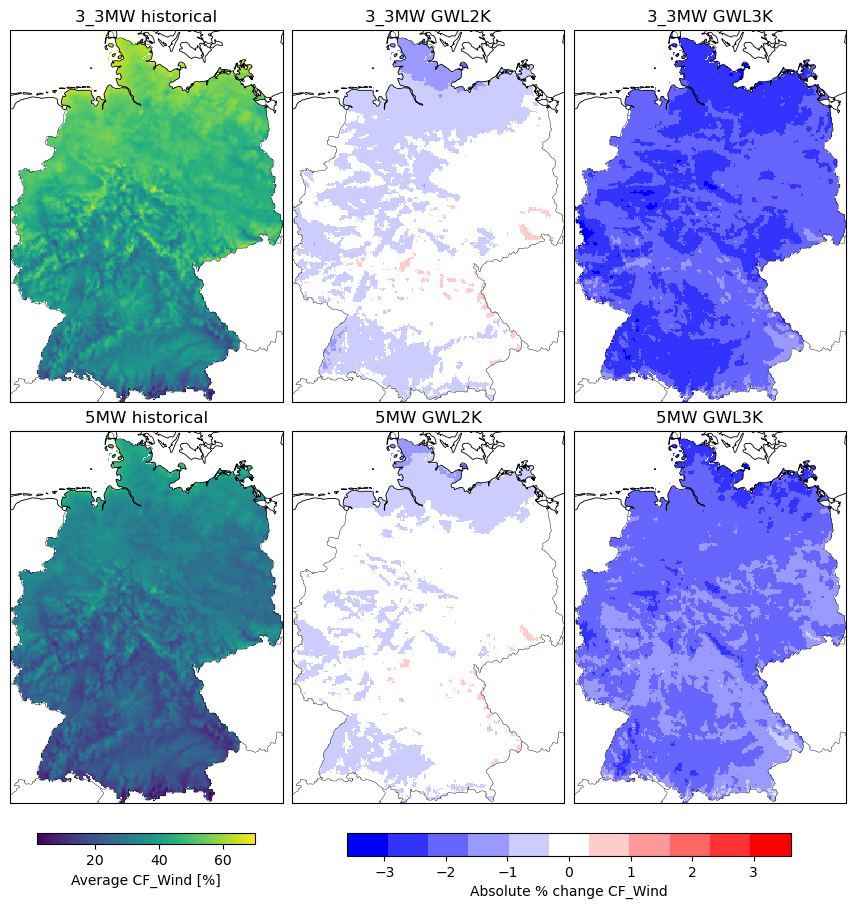

In [7]:
# Changes to CF_Wind with shared colorbars
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(pole_longitude=198.0, pole_latitude=39.25)

turbine_list = ["3_3MW", "5MW"]

# Create figure and axes grid
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(14, 9),
    subplot_kw=dict(projection=rotated_pole),
    layout="compressed",
)

# Discrete colormap for future scenarios
discrete_cmap = plt.get_cmap("bwr", 11)
discrete_cmap.set_bad(color=(0, 0, 0, 0))

# Read JSON once
with open("CF_Wind/Germany.json", "r", encoding="utf-8") as file:
    file_locations = json.load(file)

# Store pcolormesh handles for shared colorbars
historical_pms = []
future_pms = []

# Determine shared vmin/vmax for historical plots
historical_vmin = np.inf
historical_vmax = -np.inf

# First pass to compute global min/max for historical
for turbine in turbine_list:
    data_location = file_locations[turbine][
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_Wind"
    ]
    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    historical = file_1["CF_Wind"].values * 100
    cf_masked_hist = np.squeeze(np.ma.masked_equal(historical, 0))
    historical_vmin = min(historical_vmin, np.nanmin(cf_masked_hist))
    historical_vmax = max(historical_vmax, np.nanmax(cf_masked_hist))

# Second pass to plot everything
for i, turbine in enumerate(turbine_list):
    data_location = file_locations[turbine][
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_Wind"
    ]

    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
    file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

    historical = file_1["CF_Wind"].values * 100
    GWL2K = (file_2["CF_Wind"].values - file_1["CF_Wind"].values) * 100
    GWL3K = (file_3["CF_Wind"].values - file_1["CF_Wind"].values) * 100

    print(
        f"Mean value historical {turbine}: {np.nanmean(file_1['CF_Wind'].values)*100:.2f}%"
    )
    print(f"Mean value GWL2K {turbine}: {file_2['CF_Wind'].mean().item()*100:.2f}%")
    print(f"Mean value GWL3K {turbine}: {file_3['CF_Wind'].mean().item()*100:.2f}%")
    print(f"Mean difference GWL2K {turbine}: {np.nanmean(GWL2K):.2f}%")
    print(f"Mean difference GWL3K {turbine}: {np.nanmean(GWL3K):.2f}%")

    # Shared vmin/vmax for future scenarios
    v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K))
    v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K))
    v_max = max(abs(v_min), abs(v_max))
    v_min = -v_max

    files = [GWL2K, GWL3K]
    scenarios = ["GWL2K", "GWL3K"]

    lon = file_1["lon"].values
    lat = file_1["lat"].values

    # Historical subplot
    ax = axes[i, 0]
    cf_masked_hist = np.squeeze(np.ma.masked_equal(historical, 0))
    pm1 = ax.pcolormesh(
        lon,
        lat,
        cf_masked_hist,
        cmap="viridis",
        vmin=np.floor(historical_vmin),
        vmax=np.ceil(historical_vmax),
        shading="auto",
        transform=ccrs.PlateCarree(),
    )
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_title(f"{turbine} historical", fontsize=12)
    historical_pms.append(pm1)

    # Future scenarios
    for idx, (arr, scenario) in enumerate(zip(files, scenarios)):
        ax = axes[i, idx + 1]
        cf_masked = np.squeeze(np.ma.masked_equal(arr, 0))
        pm = ax.pcolormesh(
            lon,
            lat,
            cf_masked,
            cmap=discrete_cmap,
            vmin=v_min,
            vmax=v_max,
            shading="auto",
            transform=ccrs.PlateCarree(),
        )
        ax.coastlines(linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.set_title(f"{turbine} {scenario}", fontsize=12)
        future_pms.append(pm)

# Shared colorbars
fig.colorbar(
    historical_pms[0],
    ax=axes[:, 0].ravel().tolist(),
    orientation="horizontal",
    pad=0.04,
    shrink=0.8,
    label="Average CF_Wind [%]",
)

fig.colorbar(
    future_pms[0],
    ax=axes[:, 1:].ravel().tolist(),
    orientation="horizontal",
    pad=0.04,
    shrink=0.8,
    label="Absolute % change CF_Wind",
)

# Save and show
plt.savefig(
    "Publikation/Figures/CF_Wind_combined.png",
    bbox_inches="tight",
    dpi=300,
    format="png",
)
plt.show()


Mean value historical 3_3MW: 26.88%
Mean value GWL2K 3_3MW: 27.24%
Mean value GWL3K 3_3MW: 28.57%
Mean difference GWL2K 3_3MW: 0.36%
Mean difference GWL3K 3_3MW: 1.68%
Mean value historical 5MW: 40.04%
Mean value GWL2K 5MW: 40.47%
Mean value GWL3K 5MW: 42.06%
Mean difference GWL2K 5MW: 0.43%
Mean difference GWL3K 5MW: 2.02%


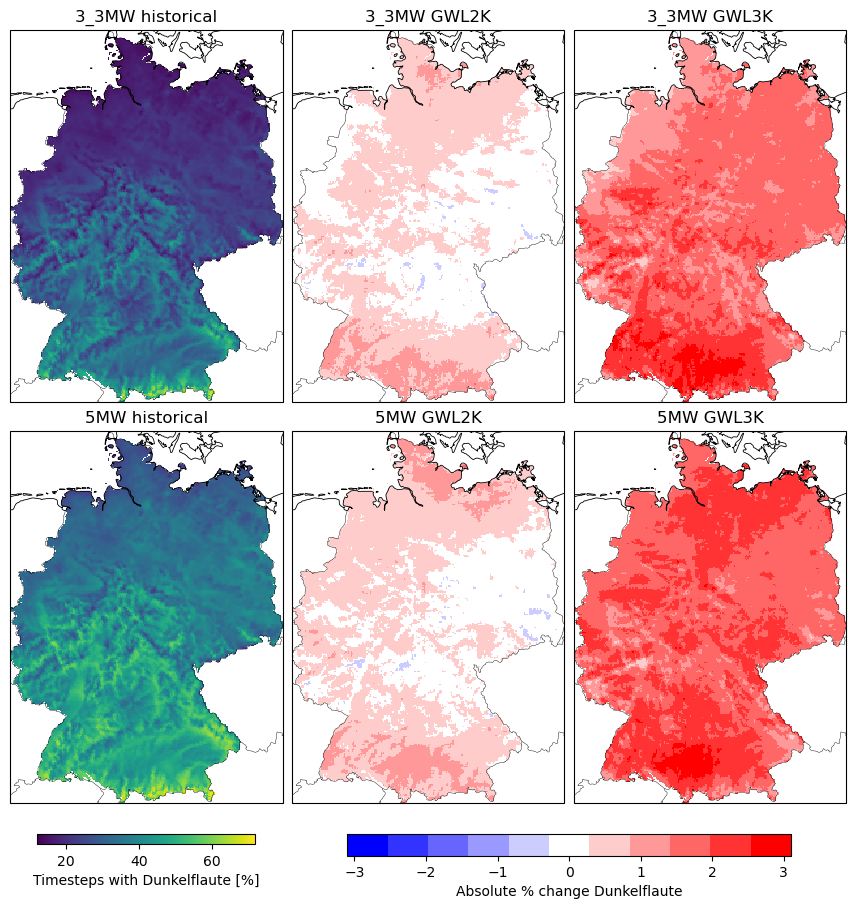

In [8]:
# Dunkelflaute Germany (figure) with shared colorbars
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(pole_longitude=198.0, pole_latitude=39.25)

turbine_list = ["3_3MW", "5MW"]

# Create figure for all turbines: 2 rows × 3 cols
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(14, 9),
    subplot_kw=dict(projection=rotated_pole),
    layout="compressed",
)

# Colormap for future scenarios
discrete_cmap = plt.get_cmap("bwr", 11)
discrete_cmap.set_bad(color=(0, 0, 0, 0))

# Read JSON once
with open("Dunkelflaute/Germany.json", "r", encoding="utf-8") as file:
    file_locations = json.load(file)

# Store pcolormesh handles for shared colorbars
historical_pms = []
future_pms = []

# Determine shared vmin/vmax for historical plots
historical_vmin = np.inf
historical_vmax = -np.inf

# First pass: find global min/max for historical
for turbine in turbine_list:
    data_location = file_locations[turbine][
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_Dunkelflaute"
    ]
    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    historical = file_1["Dunkelflaute"].values * 100
    cf_masked_hist = np.squeeze(np.ma.masked_equal(historical, 0))
    historical_vmin = min(historical_vmin, np.nanmin(cf_masked_hist))
    historical_vmax = max(historical_vmax, np.nanmax(cf_masked_hist))

# Second pass: plot everything
for i, turbine in enumerate(turbine_list):
    data_location = file_locations[turbine][
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_Dunkelflaute"
    ]
    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
    file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

    historical = file_1["Dunkelflaute"].values
    GWL2K = file_2["Dunkelflaute"].values - file_1["Dunkelflaute"].values
    GWL3K = file_3["Dunkelflaute"].values - file_1["Dunkelflaute"].values

    # Shared vmin/vmax for future scenarios
    v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
    v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
    if abs(v_min) > abs(v_max):
        v_max = abs(v_min)
    else:
        v_min = -v_max

    files = [GWL2K, GWL3K]
    scenarios = ["GWL2K", "GWL3K"]

    lon = file_1["lon"].values
    lat = file_1["lat"].values

    # Historical subplot
    ax = axes[i, 0]
    cf_hist = historical * 100
    cf_masked_hist = np.squeeze(np.ma.masked_equal(cf_hist, 0))
    pm1 = ax.pcolormesh(
        lon,
        lat,
        cf_masked_hist,
        cmap="viridis",
        vmin=np.floor(historical_vmin),
        vmax=np.ceil(historical_vmax),
        shading="auto",
        transform=ccrs.PlateCarree(),
    )
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_title(f"{turbine} historical", fontsize=12)
    historical_pms.append(pm1)

    # Future scenarios
    for idx, (arr, scenario) in enumerate(zip(files, scenarios)):
        ax = axes[i, idx + 1]
        cf_future = arr * 100
        cf_masked_future = np.squeeze(np.ma.masked_equal(cf_future, 0))
        pm = ax.pcolormesh(
            lon,
            lat,
            cf_masked_future,
            cmap=discrete_cmap,
            vmin=v_min,
            vmax=v_max,
            shading="auto",
            transform=ccrs.PlateCarree(),
        )
        ax.coastlines(linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.set_title(f"{turbine} {scenario}", fontsize=12)
        future_pms.append(pm)

    # Print stats
    print(f"Mean value historical {turbine}: {np.nanmean(historical)*100:.2f}%")
    print(f"Mean value GWL2K {turbine}: {file_2['Dunkelflaute'].mean().item()*100:.2f}%")
    print(f"Mean value GWL3K {turbine}: {file_3['Dunkelflaute'].mean().item()*100:.2f}%")
    print(f"Mean difference GWL2K {turbine}: {np.nanmean(GWL2K)*100:.2f}%")
    print(f"Mean difference GWL3K {turbine}: {np.nanmean(GWL3K)*100:.2f}%")

# Shared colorbars
fig.colorbar(
    historical_pms[0],
    ax=axes[:, 0].ravel().tolist(),
    orientation="horizontal",
    pad=0.04,
    shrink=0.8,
    label="Timesteps with Dunkelflaute [%]",
)

fig.colorbar(
    future_pms[0],
    ax=axes[:, 1:].ravel().tolist(),
    orientation="horizontal",
    pad=0.04,
    shrink=0.8,
    label="Absolute % change Dunkelflaute",
)

# Save and show
plt.savefig(
    "Publikation/Figures/Dunkelflaute_change_scenarios_combined.png",
    bbox_inches="tight",
    dpi=300,
    format="png",
)
plt.show()


In [9]:
# Changes to Dunkelflaute Germany (RCM/GCM table)
import json
from collections import defaultdict
import xarray as xr
import numpy as np


def latex_escape(s):
    return s.replace("_", "\\_")


# 1) Load data
with open("Dunkelflaute/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

# 2) Flatten out (res, gcm, rcm, scenario, mean) — always use "Year"
season = "Year"
entries = []
wind_stats = wind_stats["3_3MW"]
for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        # grab mean for Year, skip if missing
        with xr.open_dataset(wind_stats[ds_name][scen][season]["fldmean"]) as df:
            mean_val = np.nanmean(df["Dunkelflaute"].values)
        if mean_val is None:
            continue

        entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))

# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5  # total columns in the tabular environment

lines = [
    "\\begin{table}[!htbp]",
    "\\centering",
    "\\caption{Dunkelflaute grouped by Resolution, GCM, RCM and Scenario}",
    "\\label{Table:Dunkelflaute_changes}",
    "\\resizebox{\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule",
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(
        len(s_list) for rcm_dict in gcm_blocks.values() for s_list in rcm_dict.values()
    )
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\end{table}",
]

replacement_map = {
    "EC-Earth-Consortium-EC-Earth3-Veg": "EC-Earth",
    "MIROC-MIROC6":                 "MIRCO",
    "MPI-M-MPI-ESM1-2-HR":          "MPI-ESM",
    "CLMcom-BTU-ICON-2-6-5-rc":     "BTU-ICON",
    "CLMcom-KIT-CCLM-6-0-clm2":     "KIT-CCLM",
    "CLMcom-Hereon-CCLM-6-0-clm2":  "Hereon-CCLM",
    "CLMcom-Hereon-CCLM-6-0-clm3":  "Hereon-CCLM"
}

with open("Publikation/Tables/Dunkelflaute_changes.tex", "w") as out_file:
    for line in lines:
        for old, new in replacement_map.items():
            line = line.replace(old, new)
        out_file.write(f"{line}\n")


In [10]:
# Changes to Dunkelflaute Germany (regions)
import json
import xarray as xr
import numpy as np

regions = [
    "Duisburg",
    "Germany",
    "IAWAK-EE",
    "ISAP",
    "KARE",
    "KlimaKonform",
    "WAKOS",
]

lines = [
    "\\begin{table}[!htbp]",
    "\\centering",
    "\\caption{Dunkelflaute percentage by region}",
    "\\label{Table:Dunkelflaute_regions}",
    "\\begin{tabular}{lrrr}",
    "\\hline",
    "Region & Historical (\\%) & $\\Delta$ vs GWL2K (\\%) & $\\Delta$ vs GWL3K (\\%) \\",
    "\\hline",
]
for region in regions:
    with open(f"Dunkelflaute/{region}.json", "r", encoding="utf-8") as file:
        file_locations = json.load(file)
        data_location = file_locations["3_3MW"][
            "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_Dunkelflaute"
        ]
        file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
        file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
        file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

        GWL2K = file_2["Dunkelflaute"].values - file_1["Dunkelflaute"].values
        GWL3K = file_3["Dunkelflaute"].values - file_1["Dunkelflaute"].values

        lines+=[
            f"{region}: {np.nanmean(file_1['Dunkelflaute'].values)*100:.2f}\\%, "
            f"{np.nanmean(GWL2K)*100:.2f}\\%, {np.nanmean(GWL3K)*100:.2f}\\%\n"]

lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
]

with open("Publikation/Tables/Dunkelflaute_regions.tex", "w") as file:
    for item in lines:
        file.write(item + "\n")

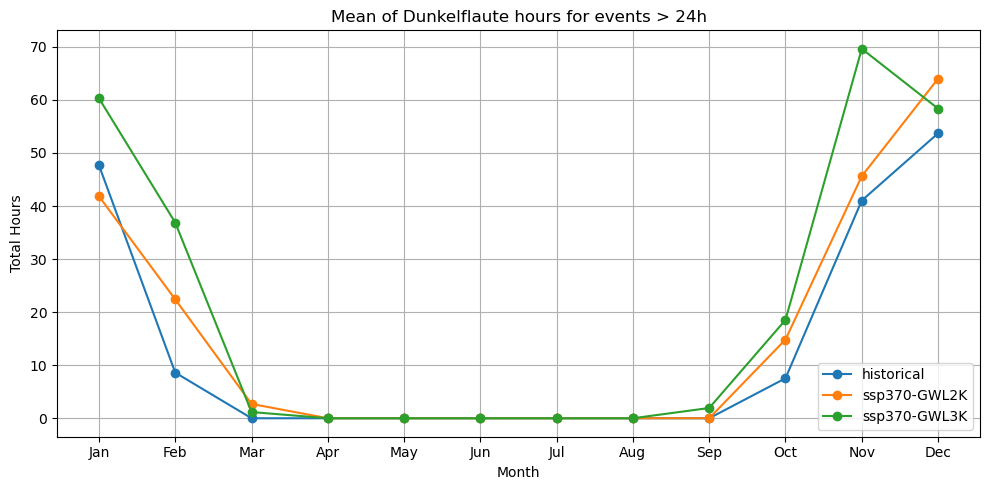

In [11]:
# Dunkelflaute monthly distribution
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json

turbine="3_3MW"
plt.figure(figsize=(10, 5))
# 1. Load your datasets
scenarios = ["historical", "ssp370-GWL2K", "ssp370-GWL3K"]
for scenario in scenarios:
    with open("CF_Wind/Germany.json", "r", encoding="utf-8") as CF_Wind_file, open(
        "CF_PV/Germany.json", "r", encoding="utf-8"
    ) as CF_PV_file:
        file_locations_CF_Wind = json.load(CF_Wind_file)
        file_locations_CF_PV = json.load(CF_PV_file)
        d_Wind = xr.open_dataset(
            file_locations_CF_Wind[turbine][
                "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_Wind"
            ][scenario]["Year"]["fldmean"]
        )
        d_PV = xr.open_dataset(
            file_locations_CF_PV[
                "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_PV"
            ][scenario]["Year"]["fldmean"]
        )
        # 2. Select the variables
        data_Wind = d_Wind["CF_Wind"]
        data_PV = d_PV["CF_PV"]

        # 3. Create a mask where both are < 0.2
        combined_mask = ((data_Wind < 0.2) & (data_PV < 0.2)).astype(int)

        # Convert to 1D NumPy array
        values = combined_mask.values.flatten()

        # Step 1: Identify sequences of 1s ≥ 24 long
        mask = np.zeros_like(values)

        counter = 0
        for i, val in enumerate(values):
            if val == 1:
                counter += 1
            else:
                if counter > 24:
                    mask[i - counter : i] = 1
                counter = 0

        # Catch final sequence if it ends at the last value
        if counter > 24:
            mask[len(values) - counter :] = 1

        # Step 2: Create a new DataArray with the filtered mask
        filtered = xr.DataArray(mask, coords={"time": data_Wind.time}, dims="time")

        # Step 3: Group by month and sum
        monthly_sum = filtered.groupby("time.month").sum()/30

        # Step 4: Plot the result

        monthly_sum.plot(marker="o", linestyle="-",label=scenario)
plt.title("Mean of Dunkelflaute hours for events > 24h")
plt.xlabel("Month")
plt.ylabel("Total Hours")
plt.grid(True)
plt.legend()
plt.xticks(
    np.arange(1, 13),
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
)
plt.tight_layout()
plt.savefig(f"Publikation/Figures/Dunkelflaute_{turbine}_monthly_distribution.png", bbox_inches="tight", format="png", dpi=300)

plt.show()

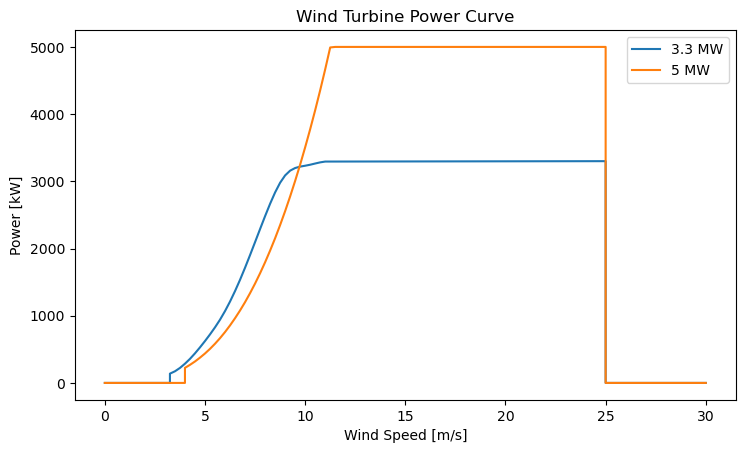

In [12]:
# Wind turbine power curve
import numpy as np
import matplotlib.pyplot as plt
_WIND_3_3 = np.array(
    [   0,
        3.25,
        3.25,
        3.5,
        3.75,
        4.0,
        4.25,
        4.5,
        4.75,
        5.0,
        5.25,
        5.5,
        5.75,
        6.0,
        6.25,
        6.5,
        6.75,
        7.0,
        7.25,
        7.5,
        7.75,
        8.0,
        8.25,
        8.5,
        8.75,
        9.0,
        9.25,
        9.5,
        9.75,
        10.0,
        10.25,
        10.5,
        10.75,
        11.0,
        25,
        25,
        30,
    ],
    dtype=np.float32,
)

_POWER_3_3 = (
    np.array(
        [0,
         0,
            138,
            173,
            223,
            286,
            358,
            440,
            529,
            623,
            722,
            827,
            941,
            1069,
            1211,
            1367,
            1535,
            1715,
            1903,
            2096,
            2290,
            2482,
            2666,
            2835,
            2979,
            3088,
            3159,
            3198,
            3219,
            3232,
            3247,
            3265,
            3282,
            3294,
            3300,
            0,
            0
        ],
        dtype=np.float32,
    )
)

_WIND_5 = np.array(
    [   0,
        4,
        4,
        4.25,
        4.5,
        4.75,
        5,
        5.25,
        5.5,
        5.75,
        6,
        6.25,
        6.5,
        6.75,
        7,
        7.25,
        7.5,
        7.75,
        8,
        8.25,
        8.5,
        8.75,
        9,
        9.25,
        9.5,
        9.75,
        10,
        10.25,
        10.5,
        10.75,
        11,
        11.25,
        11.5,
        25,
        25,
        30
    ],
    dtype=np.float32,
)

_POWER_5 = (
    np.array(
        [
            0,
            0,
            224,
            269,
            319,
            376,
            438,
            507,
            583,
            666,
            757,
            856,
            963,
            1078,
            1202,
            1336,
            1479,
            1632,
            1795,
            1969,
            2153,
            2349,
            2556,
            2775,
            3006,
            3249,
            3506,
            3775,
            4058,
            4355,
            4666,
            4992,
            5000,
            5000,
            0,
            0
        ],
        dtype=np.float32,
    )
)
fig, ax = plt.subplots(figsize=(8.53, 4.8)) 
#ax.plot(df["Wind Speed [m/s]"],df["Power [kW]"],label="5MW")
ax.plot(_WIND_3_3,_POWER_3_3,label="3.3 MW")
ax.plot(_WIND_5,_POWER_5,label="5 MW")
ax.set_xlabel("Wind Speed [m/s]")
ax.set_ylabel("Power [kW]")
ax.set_title("Wind Turbine Power Curve")
plt.legend()
plt.savefig("Publikation/Figures/wind_turbine_power_curve.png", bbox_inches="tight", format="png", dpi=300)
plt.show()